## Prioritizer Model

Trained model for classification and prioritization for ALFABURST events based on the labelled feature set from  featureBuilder.ipynb.

### Classifier model

Probabalistic classifier using random forests.

### Labels

#### RFI

* 1 : Unclipped RFI/Noise
* 2 : Wide-band, long-duration in time clipped RFI (2016+)
* 3 : Wide-band, short-duration in time clipped RFI (2016+)
* 4 : Wide-band, short duration clipped RFI (2015)
* 5 : Sharp bandpass transition
* 6 : Wide-band, bursty clipped RFI (2015)
* 7 : Error in spectra captue or replacement
* 8 : Systematic int/float overflow

#### Astronomical

* 0 : Interesting, follow up
* 9 : Known Pulsar

### Classifier

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn.ensemble
import sklearn.multiclass
import sklearn.model_selection
from sklearn.model_selection import GridSearchCV

#Read in preprocessed dataframes:
featureDf = pd.read_pickle('./processed.files/labelled/featureDfnew')
labelledDf = pd.read_pickle('./processed.files/labelled/labelledDfnew')

#Read in preprocessed numpy arrays:
preProcFeats = np.load('./redfeatnew.npy')
preProcLabels = np.load('./processed.files/labelled/labelsnew.npy')

In [111]:
k_fold = sklearn.model_selection.StratifiedKFold(n_splits=3, shuffle=True)

In [112]:
clf = sklearn.multiclass.OneVsRestClassifier(estimator=sklearn.ensemble.RandomForestClassifier(bootstrap=True, 
            class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=420, verbose=0,
            warm_start=False),
            n_jobs=1)

#param_grid = {'estimator__n_estimators': [10, 20, 40, 80], 'estimator__max_features': [100, 400, 1600, 6400]}

# clf = sklearn.model_selection.GridSearchCV(randForest, param_grid=param_grid, scoring='neg_log_loss',\
#                                            cv=k_fold, n_jobs=-1)

# clf.fit(preProcFeats, preProcLabels) #fits data to already labelled set and finds best parameters for fitting
# #print clf.cv_results_
# print clf.best_score_                     
# print clf.best_estimator_
#clf.best_estimator is my randforest classifier that has had it's hyperparamaters tuned by gridsearched


In [113]:
print np.mean(sklearn.model_selection.cross_val_score(clf, preProcFeats, preProcLabels,\
                                              cv=k_fold, n_jobs=-1, scoring='neg_log_loss'))


# Train/Test Validation
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(preProcFeats,\
                                                            preProcLabels, test_size=0.25, random_state=420) #one quarter of data used for testing
probs = clf.fit(X_train, y_train).predict_proba(X_test) #return an array of predicted values
score = sklearn.metrics.log_loss(y_test, probs)
confuseMatrix = sklearn.metrics.confusion_matrix(y_test, clf.fit(X_train, y_train).predict(X_test))
print confuseMatrix

-0.588485450064
[[   5   10    6    0    1    1    0    0]
 [   2 1043   13    0   11   13    2    2]
 [   2   47  195    3   10   85    1    1]
 [   0    2    6   13    4   53    0    0]
 [   0    5   10    5   70   29    0    1]
 [   0    5   11    6   13  763    0    4]
 [   0    2    0    0    0    2  412    2]
 [   1    3    5    0    0    5    1  214]]


(8, 8)


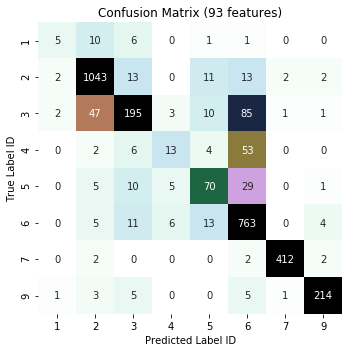

In [114]:

classLabels = ['1', '2', '3', '4', '5', '6', '7', '9']

print confuseMatrix.shape
normConfuseMatrix = np.zeros(confuseMatrix.shape)
for col in np.arange(confuseMatrix.shape[1]):
    normConfuseMatrix[:,col] = confuseMatrix[:,col] / float(confuseMatrix[:,col].max())

#turn the matrix into a dataframe    
#dfCM = pd.DataFrame(normConfuseMatrix, index = [i for i in classLabels], columns = [i for i in classLabels])
dfCM = pd.DataFrame(confuseMatrix, index = [i for i in classLabels], columns = [i for i in classLabels])

#plot the confusion matrix visually using a heatmap
colormap = plt.cm.cubehelix_r
fig = plt.figure(figsize=(5,5)) # (width, height)
sns.heatmap(dfCM, annot=True, vmin = 0, vmax = 100, fmt='d', cbar=False, cmap = colormap)
#sns.heatmap(dfCM, annot=True, cbar=False)
plt.xlabel('Predicted Label ID')
plt.ylabel('True Label ID')
plt.title('Confusion Matrix (%d features)'%(preProcFeats.shape[1]))

plt.tight_layout()
plt.savefig('confusion_matrix.png')

## Binarised

In [115]:
preProcFeatsbin = np.load('./redfeatbin.npy')

In [116]:
#Binarise labels:
preProcLabels[preProcLabels != 9] = 0
preProcLabels[preProcLabels == 9] = 1

In [117]:
print np.mean(sklearn.model_selection.cross_val_score(clf, preProcFeatsbin, preProcLabels,\
                                              cv=k_fold, n_jobs=-1, scoring='neg_log_loss'))


# Train/Test Validation
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(preProcFeats,\
                                                            preProcLabels, test_size=0.25, random_state=420) #one quarter of data used for testing
probsbin = clf.fit(X_train, y_train).predict_proba(X_test) #return an array of predicted values

-0.0465413111629


In [118]:
# # Set positive detection probability as 0.99 based on ROC graph
# neg, pos = np.hsplit(predictTestX, 2)
# print neg.shape
# idx = pos[pos < 0.99].astype(int)
# pos[idx] = 0
# neg[idx] = 1

# predictTestX = np.hstack((neg, pos))

In [119]:
confuseMatrix = sklearn.metrics.confusion_matrix(y_test, clf.fit(X_train, y_train).predict(X_test))

(2, 2)


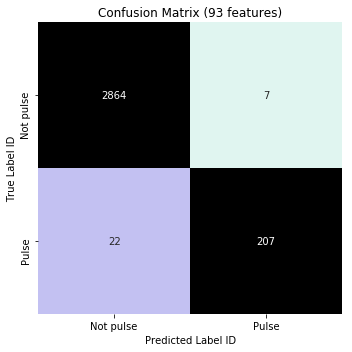

In [120]:
classLabels = ['Not pulse', 'Pulse']

print confuseMatrix.shape
normConfuseMatrix = np.zeros(confuseMatrix.shape)
for col in np.arange(confuseMatrix.shape[1]):
    normConfuseMatrix[:,col] = confuseMatrix[:,col] / float(confuseMatrix[:,col].max())

#turn the matrix into a dataframe    
#dfCM = pd.DataFrame(normConfuseMatrix, index = [i for i in classLabels], columns = [i for i in classLabels])
dfCM = pd.DataFrame(confuseMatrix, index = [i for i in classLabels], columns = [i for i in classLabels])

#plot the confusion matrix visually using a heatmap
colormap = plt.cm.cubehelix_r
fig = plt.figure(figsize=(5,5)) # (width, height)
sns.heatmap(dfCM, annot=True, vmin = 0, vmax = 100, fmt='d', cbar=False, cmap = colormap)
#sns.heatmap(dfCM, annot=True, cbar=False)
plt.xlabel('Predicted Label ID')
plt.ylabel('True Label ID')
plt.title('Confusion Matrix (%d features)'%(preProcFeats.shape[1]))

plt.tight_layout()
plt.savefig('confusion_matrix.png')

## True pulses inspected vs total time series' inspected

In [121]:
clf = sklearn.multiclass.OneVsRestClassifier(estimator=sklearn.ensemble.RandomForestClassifier(bootstrap=True, 
            class_weight=None, criterion='gini', max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=420, verbose=0, warm_start=False), n_jobs=1)


preProcLabels = np.load('./processed.files/labelled/labelsnew.npy')

split = sklearn.model_selection.StratifiedKFold(n_splits=3).split(preProcFeats, preProcLabels)

# Multiclass
count = 0
for train, test in split:
    count += 1
    X_train = preProcFeats[train]
    X_test = preProcFeats[test]    
    y_train = preProcLabels[train]
    y_test = preProcLabels[test]
    npulses = np.argwhere(y_test==9).flatten().size
    
    probs = clf.fit(X_train, y_train).predict_proba(X_test)
       
    probs = np.c_[probs, y_test]
    probs = probs[probs[:,7].argsort()][::-1]
    
    detcount = 0
    detections = np.zeros(probs.shape[0])
    
    for i in range(probs.shape[0]):
        if probs[i, 8] == 9:
            detcount += 1        
        detections[i] = detcount    
    detections = detections/npulses
    if detections.size < 4135:
        for i in range(4135-detections.size):
            detections = np.append(detections, 1)
    
    if count == 1:
        detectpct = detections
    else:
        detectpct = np.vstack((detectpct, detections))

print detectpct.shape
detectpct = np.mean(detectpct, axis=0)
print detectpct.shape

(3, 4135)
(4135,)


In [122]:
preProcLabels[preProcLabels != 9] = 0

preProcLabels[preProcLabels == 9] = 1

split = sklearn.model_selection.StratifiedKFold(n_splits=3).split(preProcFeats, preProcLabels)

# Binary
count = 0
for train, test in split:
    count += 1
    X_train = preProcFeatsbin[train]
    X_test = preProcFeatsbin[test]    
    y_train = preProcLabels[train]
    y_test = preProcLabels[test]
    npulses = np.argwhere(y_test==1).flatten().size
    
    probs = clf.fit(X_train, y_train).predict_proba(X_test)
       
    probs = np.c_[probs, y_test]
    probs = probs[probs[:,1].argsort()][::-1]
    
    detcount = 0
    detections = np.zeros(probs.shape[0])
    
    for i in range(probs.shape[0]):
        if probs[i, 2] == 1:
            detcount += 1        
        detections[i] = detcount    
    detections = detections/npulses
    if detections.size < 4135:
        for i in range(4135-detections.size):
            detections = np.append(detections, 1)
    
    if count == 1:
        detectpctbin = detections
    else:
        detectpctbin = np.vstack((detectpct, detections))

print detectpctbin.shape
detectpctbin = np.mean(detectpctbin, axis =0)

(2, 4135)


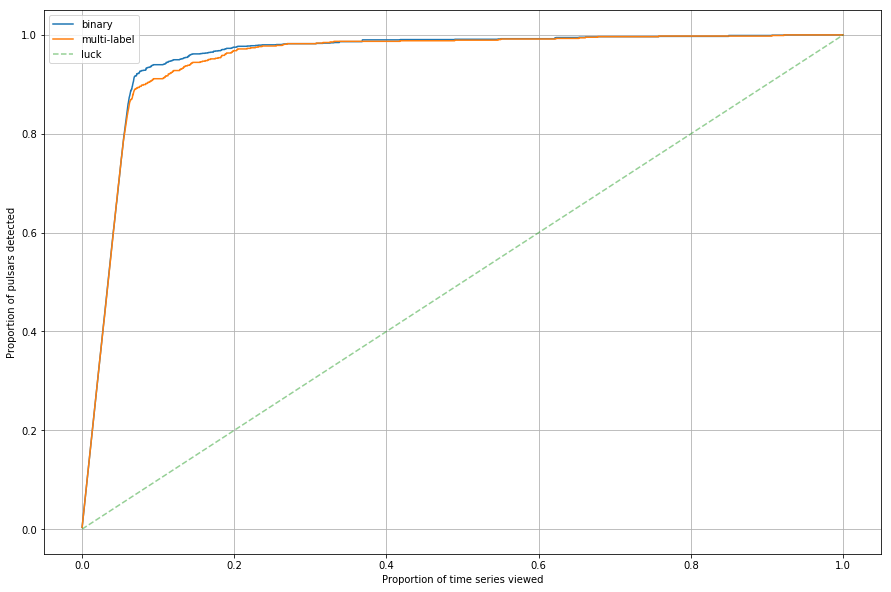

In [123]:
candidatepct = np.arange(detectpct.size)+1
candidatepct = candidatepct.astype(float)
#print candidatepct
candidatepct = candidatepct/candidatepct.size
candidatepct = candidatepct.astype(float)
#print candidatepct

#print npulses
#luckchance = 1/float(npulses)
#print luckchance
luckstep = 1/float(candidatepct.size)
luckline = np.arange(0,1,luckstep)

plt.figure()
plt.figure(figsize=(15,10))
plt.xlabel('Proportion of time series viewed')
plt.ylabel('Proportion of pulsars detected')
plt.plot(candidatepct, detectpctbin,  label = 'binary')
plt.plot(candidatepct, detectpct,  label = 'multi-label')
plt.plot(candidatepct, luckline, '--', alpha = 0.5,  label = 'luck')
plt.savefig('graphs/detection.png')
plt.grid()
plt.legend()
plt.show()

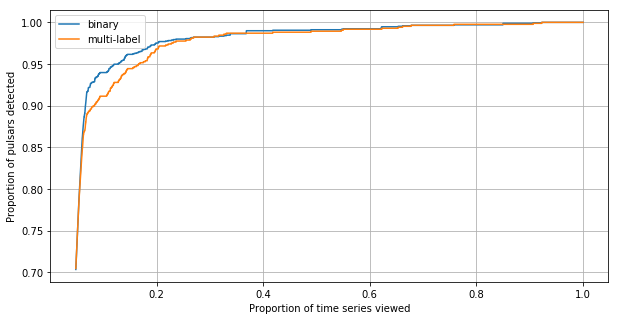

In [124]:
candidatepct = np.arange(detectpct.size)+1
candidatepct = candidatepct.astype(float)
#print candidatepct
candidatepct = candidatepct/candidatepct.size
candidatepct = candidatepct.astype(float)
#print candidatepct

#print npulses
#luckchance = 1/float(npulses)
#print luckchance
luckstep = 1/float(candidatepct.size)
luckline = np.arange(0,1,luckstep)

plt.figure()
plt.figure(figsize=(10,5))
plt.xlabel('Proportion of time series viewed')
plt.ylabel('Proportion of pulsars detected')
plt.plot(candidatepct[200:], detectpctbin[200:],  label = 'binary')
plt.plot(candidatepct[200:], detectpct[200:],  label = 'multi-label')
#plt.plot(candidatepct, luckline, '--', alpha = 0.5,  label = 'luck')
plt.savefig('graphs/detectionslice.png')
plt.grid()
plt.legend()
plt.show()

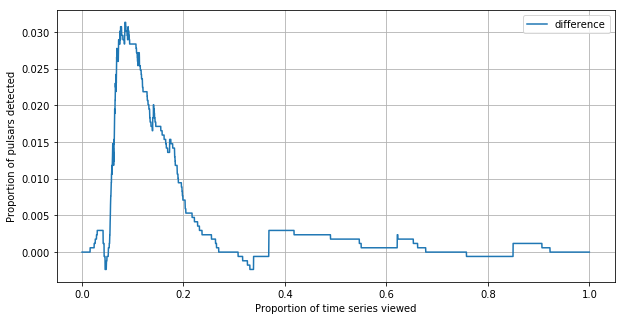

In [126]:
plt.figure()
plt.figure(figsize=(10,5))
plt.xlabel('Proportion of time series viewed')
plt.ylabel('Proportion of pulsars detected')
plt.plot(candidatepct, detectpctbin-detectpct,  label = 'difference')
plt.grid()
plt.legend()
plt.savefig('graphs/detectiondiff.png')
plt.show()

## Draw a histogram of predicted probabilities of each class for true class 9 labels

In [ ]:
# pulseargs = np.argwhere(y_test == 1).flatten()
# labellegend = 'not pulse','pulse'

In [ ]:
pulseprobsbin = probsbin[:,1]
pulseprobsbin = pulseprobsbin[pulseargs]

notpulseprobsbin = probsbin[:,0]
notpulseprobsbin = notpulseprobsbin[pulseargs]

binhist = []
binhist.append(notpulseprobsbin)
binhist.append(pulseprobsbin)

plt.figure(figsize=(20,10))
plt.figure()
plt.xlabel('Predicted probability')
plt.ylabel('Counts')
plt.hist(binhist, bins=50, histtype='bar',stacked = True, label=labellegend)
plt.xlim((0.3, 0.8))
#plt.savefig('graphs/cv.png')
plt.legend()
plt.show()

In [ ]:
pulseprobs = probs[:,7]
pulseprobs = probs[pulseargs]
print pulseprobs.shape

notpulseprobs = probs[:,:6].flatten()
notpulseprobs = notpulseprobs[pulseargs]

hist = []
hist.append(notpulseprobs)
hist.append(pulseprobs)

plt.figure()
plt.xlabel('Predicted probability')
plt.ylabel('Counts')
plt.hist(hist, bins=50, histtype='bar',stacked = True, label=labellegend)
#plt.savefig('graphs/cv.png')
plt.legend()
plt.show()

In [ ]:
#fetch probabilities for timeseries that are class 9, and tiemseries that are not class 9


pulse = probs[np.argwhere(y_test == 9).flatten()][:,7]
notpulse = probs[np.argwhere(y_test != 9).flatten()][:,:6]

#fig, ax = plt.subplots(figsize=(5,3.5)) # (width, height)

plt.figure(figsize=(10,10))

sns.distplot(pulse, kde=False, bins=50)
#sns.distplot(notpulse, kde=False, bins=50)
plt.xlabel('Probability of being in class 9')
plt.ylabel('Counts')
plt.title('Prediction of label 9')
plt.xlim(0.25, 1.)
plt.ylim(0, 25)